<a href="https://colab.research.google.com/github/profugohenrique/spoincd/blob/master/INCD22102025CurvaAprendizado.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

# Carregar dados
data = load_breast_cancer()
X, y = data.data, data.target
feature_names = data.feature_names

# Dividir dados
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

### Pipeline 1: Random Forest com GridSearch
rf_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(random_state=42))
])

rf_param_grid = {
    'rf__n_estimators': [100, 200, 300],
    'rf__max_depth': [5, 10, 15, None],
    'rf__min_samples_split': [2, 5, 10],
    'rf__min_samples_leaf': [1, 2, 4]
}

rf_grid = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

rf_grid.fit(X_train, y_train)

### Pipeline 2: Logistic Regression com Regularização
lr_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(random_state=42, max_iter=1000))
])

lr_param_grid = {
    'lr__C': np.logspace(-3, 3, 7),
    'lr__penalty': ['l1', 'l2'],
    'lr__solver': ['liblinear']
}

lr_grid = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

lr_grid.fit(X_train, y_train)

### Comparação dos Modelos
print("=== RANDOM FOREST ===")
print(f"Melhores parâmetros: {rf_grid.best_params_}")
print(f"Melhor score CV: {rf_grid.best_score_:.4f}")

print("\n=== LOGISTIC REGRESSION ===")
print(f"Melhores parâmetros: {lr_grid.best_params_}")
print(f"Melhor score CV: {lr_grid.best_score_:.4f}")

### Avaliação no Teste
best_model = rf_grid.best_estimator_ if rf_grid.best_score_ > lr_grid.best_score_ else lr_grid.best_estimator_

y_pred = best_model.predict(X_test)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== MELHOR MODELO NO TESTE ===")
print(classification_report(y_test, y_pred))
print(f"Matriz de Confusão:\n{confusion_matrix(y_test, y_pred)}")

### Análise de Importância de Features (se for Random Forest)
if hasattr(best_model.named_steps['rf'], 'feature_importances_'):
    importances = best_model.named_steps['rf'].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_names,
        'importance': importances
    }).sort_values('importance', ascending=False)

    print("\n=== TOP 10 FEATURES MAIS IMPORTANTES ===")
    print(feature_importance_df.head(10))

=== RANDOM FOREST ===
Melhores parâmetros: {'rf__max_depth': 10, 'rf__min_samples_leaf': 4, 'rf__min_samples_split': 10, 'rf__n_estimators': 100}
Melhor score CV: 0.9604

=== LOGISTIC REGRESSION ===
Melhores parâmetros: {'lr__C': np.float64(0.1), 'lr__penalty': 'l2', 'lr__solver': 'liblinear'}
Melhor score CV: 0.9802

=== MELHOR MODELO NO TESTE ===
              precision    recall  f1-score   support

           0       0.98      0.98      0.98        42
           1       0.99      0.99      0.99        72

    accuracy                           0.98       114
   macro avg       0.98      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Matriz de Confusão:
[[41  1]
 [ 1 71]]


KeyError: 'rf'

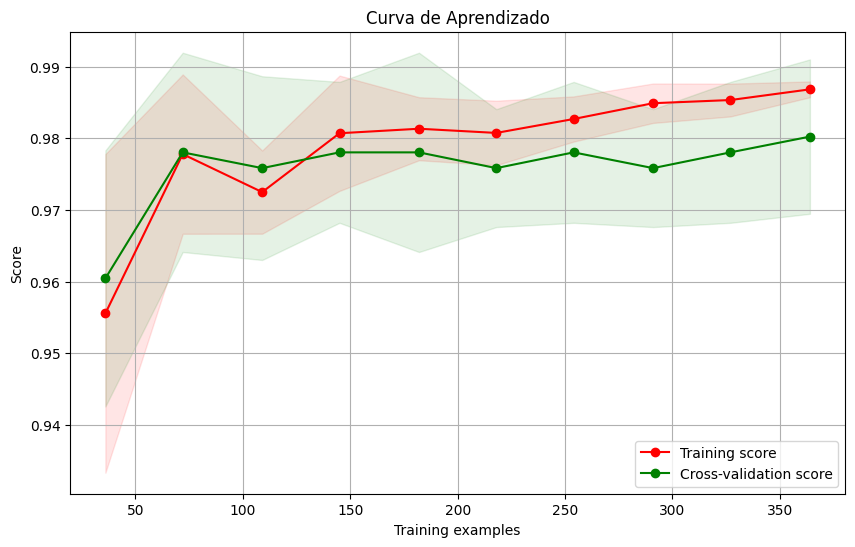

In [2]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt

def plot_learning_curve(estimator, title, X, y, cv=5):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10),
        scoring='accuracy'
    )

    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)

    plt.figure(figsize=(10, 6))
    plt.title(title)
    plt.xlabel("Training examples")
    plt.ylabel("Score")

    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1, color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

    plt.legend(loc="best")
    plt.show()

# Plotar curva de aprendizado do melhor modelo
plot_learning_curve(best_model, "Curva de Aprendizado", X_train, y_train)

In [4]:
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.decomposition import PCA

# Definição do espaço de busca
search_space = {
    'algorithms': [
        {'name': 'RandomForest', 'model': RandomForestClassifier},
        {'name': 'SVM', 'model': SVC}
    ],
    'preprocessors': [
        {'name': 'StandardScaler', 'transformer': StandardScaler},
        {'name': 'MinMaxScaler', 'transformer': MinMaxScaler},
        {'name': 'PCA+Scaler', 'transformer': [PCA(), StandardScaler()]}
    ],
    'hyperparams': {
        'RandomForest': {
            'n_estimators': [50, 100, 200],
            'max_depth': [3, 5, None]
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf']
        }
    }
}

# Resultado ideal que queremos encontrar
A_star = {'name': 'RandomForest', 'model': RandomForestClassifier}
P_star = {'name': 'StandardScaler', 'transformer': StandardScaler}
λ_star = {'n_estimators': 100, 'max_depth': 5}

# Esta combinação minimiza: E[L(y, f_{A,P,λ}(x))]

In [ ]:
#Explicação da Função de Perda Esperada
#E[L(y, f_{A,P,λ}(x))] significa:
#"O valor esperado da função de perda entre os valores verdadeiros (y) e as predições do modelo (f_{A,P,λ}(x))"
# Diferentes funções de perda possíveis
#O valor esperado E[] considera:
#Múltiplas divisões treino/validação (cross-validation)
#
#Diferentes amostras dos dados
#
#Robustez estatística

def loss_function(y_true, y_pred, loss_type='cross_entropy'):
    if loss_type == 'mse':  # Regressão
        return np.mean((y_true - y_pred) ** 2)
    elif loss_type == 'cross_entropy':  # Classificação
        return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    elif loss_type == 'accuracy':  # Acurácia
        return 1 - np.mean(y_true == y_pred)

In [ ]:
#Analogia com Otimização Tradicional
#Otimização Regular:
# Encontrar melhores parâmetros para um algoritmo fixo
θ* = argmin L(y, f_θ(x))

# Exemplo: Ajustar apenas os pesos de uma regressão linear

#Otimização AutoML:

# Encontrar melhor algoritmo + pré-processamento + hiperparâmetros
(A*, P*, λ*) = argmin E[L(y, f_{A,P,λ}(x))]

# Exemplo: Testar Random Forest, SVM, XGBoost com diferentes
# escalonamentos e combinações de hiperparâmetros

#Complexidade Computacional
#O espaço de busca é combinatório:

#Número total de combinações =
#  (Nº de algoritmos) × (Nº de pré-processadores) × (Nº de combinações de hiperparâmetros)

In [2]:
class SimpleAutoML:
    def __init__(self):
        self.best_score = float('inf')
        self.best_config = None

    def search(self, X, y):
        # Espaço de busca reduzido para exemplo
        configurations = [
            {
                'algorithm': RandomForestClassifier,
                'preprocessor': StandardScaler,
                'hyperparams': {'n_estimators': 100, 'max_depth': 5}
            },
            {
                'algorithm': SVC,
                'preprocessor': StandardScaler,
                'hyperparams': {'C': 1.0, 'kernel': 'rbf'}
            }
        ]

        for config in configurations:
            # Calcular perda esperada para esta configuração
            score = self.evaluate_configuration(config, X, y)

            # Atualizar melhor configuração se necessário
            if score < self.best_score:
                self.best_score = score
                self.best_config = config

        return self.best_config  # Retorna (A*, P*, λ*)

    def evaluate_configuration(self, config, X, y):
        from sklearn.model_selection import cross_val_score

        pipeline = Pipeline([
            ('preprocessor', config['preprocessor']()),
            ('algorithm', config['algorithm'](**config['hyperparams']))
        ])

        # Usar negative MSE como score (maior é melhor)
        scores = cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error')
        return -np.mean(scores)  # Converter para perda (menor é melhor)